# VizDoom Playground

In [2]:
import itertools as it
import json
import os

import cv2
import gym
from gym.spaces import Box, Discrete
import matplotlib.pyplot as plt
import numpy as np
import torch
import vizdoom as vzd

from rlpyt.envs.vizdoom.vizdoom_env import VizDoomEnv
import rlpyt.models.resnet as resnet
from rlpyt.models.dqn.dsr.tcf_model import FixedVizDoomModel

vzd_dir = 'vizdoom_data'
import keras
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

from itertools import tee, islice
def nwise(iterable, n=2):                                                      
    iters = tee(iterable, n)                                                     
    for i, it in enumerate(iters):                                               
        next(islice(it, i, i), None)                                               
    return zip(*iters)   

Using TensorFlow backend.
/home/choang/anaconda3/envs/rlpyt/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/choang/anaconda3/envs/rlpyt/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/choang/anaconda3/envs/rlpyt/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/choang/anaconda3/

## Player Control

In [ ]:
game = vzd.DoomGame()
game.load_config('vizdoom_data/train_SPTM.cfg')
game.set_screen_resolution(vzd.ScreenResolution.RES_640X480)
game.set_mode(vzd.Mode.SPECTATOR)
game.set_seed(100)
game.set_doom_map('map05')
game.set_window_visible(True)

In [ ]:
game.init()
game.new_episode()
i = 0
while not game.is_episode_finished():
    s = game.get_state()
    print('Step {}'.format(i))
    i += 1
    game.advance_action()
    a = game.get_last_action()
    r = game.get_last_reward()
game.close()

## Replay Episode

In [ ]:
game = vzd.DoomGame()
game.load_config('vizdoom_data/my_way_home_control.cfg')
game.init()
game.replay_episode('../data/local/20200722/vizdoom/run_0/eval_run_0_itr_0.lmp')
while not game.is_episode_finished():
    game.advance_action()
game.close()

## Position Prediction Exploration

In [ ]:
np.random.seed(333)

In [ ]:
env = VizDoomEnv('../experiments/vizdoom/train_SPTM.cfg', 100, [595, 1200], 270, grayscale=False, num_samples=20000, map_id='map05')

In [ ]:
model = FixedVizDoomModel('../../sptm/experiments/0103_R/models/model_weights.h5', final_feature_size=2)

In [ ]:
weights = torch.load('../data/local/20200801/vizdoom/run_1/itr_299999.pkl')
model.load_state_dict(weights['agent_state_dict']['feature_model'])

In [ ]:
device = torch.device('cuda', index=0)
model.to(device)

In [ ]:
states = np.stack([state for state, _ in env.sample_states])
positions = np.array([position for _, position in env.sample_states])

In [ ]:
positions[:, 0] = positions[:, 0] / env.max_x
positions[:, 1] = positions[:, 1] / env.max_y

In [ ]:
batch_size = 64
batches = len(states) // batch_size

In [ ]:
diffs = []
for ind in range(batches):
    X = torch.cuda.FloatTensor(states[ind * batch_size: (ind + 1) * batch_size], device=device)
    features = model(X)
    pred_y = model(features, mode='output').detach().cpu().numpy()
    true_y = positions[ind * batch_size: (ind + 1) * batch_size]
    diffs.append(abs(true_y - pred_y))

In [ ]:
diffs = np.concatenate(diffs)

In [ ]:
mean_x = diffs[:, 0].mean()
mean_x

In [ ]:
mean_y = diffs[:, 1].mean()
mean_y

In [ ]:
np.sqrt(mean_x ** 2 + mean_y ** 2)

## Cosine Similarity Exploration

In [ ]:
np.random.seed(333)

In [ ]:
env = VizDoomEnv('../experiments/vizdoom/train_SPTM.cfg', 100, [595, 1200], 270, grayscale=False, map_id='map05')

In [ ]:
env.reset()

In [ ]:
env.state.game_variables

In [ ]:
env.plot_topdown()

In [ ]:
env.sample_states[0][1]

In [ ]:
plt.imshow(np.transpose(env.sample_states[1][0], [1, 2, 0]))

In [ ]:
plt.imshow(np.transpose(env.get_obs_at([595, 1200])[0], [1, 2, 0]))

In [ ]:
positions = np.array([pos for _, pos in env.sample_states])

In [ ]:
env.game.get_state().objects[1].position_y

In [ ]:
env.plot_topdown()
plt.scatter(positions[:, 0], positions[:, 1])

In [ ]:
env.plot_topdown()
plt.scatter(env.sample_sectors[:, 0], env.sample_sectors[:, 1], c=env.sample_sectors[:, 2], s=100)

In [ ]:
start_state = env.sample_states[0]

In [ ]:
start_state_features = start_state[0].flatten() / np.linalg.norm(start_state[0])

In [ ]:
similarities = []

In [ ]:
for state, position in env.sample_states:
    state_features = state.flatten() / np.linalg.norm(state)
    similarity = np.dot(start_state_features, state_features)
    similarities.append((*position, similarity))
#     plt.figure(figsize=(7, 7))
#     plt.imshow(np.transpose(state, [1, 2, 0]))
#     plt.title('{} {}: {}'.format(*position, similarity))

In [ ]:
similarities = np.array(similarities)

In [ ]:
plt.figure(figsize=(7, 7))
env.plot_topdown()
plt.scatter(similarities[:, 0], similarities[:, 1], c=range(len(similarities)), s=100)
plt.colorbar()

## Cosine Similarity Exploration 2: SPTM Retrieval Network Features

In [2]:
np.random.seed(333)

In [3]:
env = VizDoomEnv('../experiments/vizdoom/train_SPTM.cfg', 100, [595, 1200], 270, grayscale=False, map_id='map05')

In [7]:
sptm_model = resnet.ResnetBuilder.build_siamese_resnet_18((6, 120, 160), 2)
sptm_model.load_weights('../../sptm/experiments/0103_R/models/model_weights.h5')
sptm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
env.set_record_files(['vizdoom_data/test.lmp'])

In [9]:
obs = env.reset()

In [10]:
states = []
positions = []
features = []

In [11]:
while True:
    state, reward, done, info = env.step(np.random.randint(env.action_space.n))
    states.append(state)
    positions.append(info.position)
    if done:
        break
states = np.array(states)
positions = np.array(positions)

In [12]:
positions[:, 0] *= env.max_x
positions[:, 1] *= env.max_y

In [13]:
for state in states:
    feature = sptm_model.layers[3].predict(np.expand_dims(np.transpose(state, [1, 2, 0]), axis=0)).squeeze()
    features.append(feature)
features = np.array(features)
norm_features = features / np.linalg.norm(features, ord=2, keepdims=True, axis=1)

In [72]:
stacked_size = 20
stacked_features = np.array(list(nwise(np.concatenate((features, np.zeros((stacked_size - 1, 512)))), stacked_size)))
stacked_features = stacked_features.reshape(stacked_features.shape[0], -1)
norm_stacked_features = stacked_features / np.linalg.norm(stacked_features, ord=2, keepdims=True, axis=1)

In [122]:
sequence_length = 20
sequences = np.array(list(nwise(np.concatenate((norm_features, np.zeros((sequence_length - 1, 512)))), sequence_length)))

In [141]:
compare_idx = 500

In [142]:
sequence_similarities = np.sum(sequences[compare_idx] * sequences, axis=-1)
similarities = np.median(sequence_similarities, axis=-1)
# similarities = np.sum(norm_stacked_features * norm_stacked_features[compare_idx], axis=1)
# similarities = np.sum(norm_features * norm_features[compare_idx], axis=1)

In [143]:
high_sim = similarities > 0.90
med_sim = similarities > 0.80
low_sim = similarities > 0.70

In [144]:
indices = np.arange(len(similarities))[high_sim]
print(indices)
indices = np.arange(len(similarities))[med_sim]
print(indices)
indices = np.arange(len(similarities))[low_sim]
print(indices)

[497 498 499 500 501 502 503]
[476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493
 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508]
[ 474  475  476  477  478  479  480  481  482  483  484  485  486  487
  488  489  490  491  492  493  494  495  496  497  498  499  500  501
  502  503  504  505  506  507  508  509  528  529  530  532  540  541
  542  543  544  545  546  547  548  549  550  551  552  553  554 1543
 1544 1545 1546 1547 1548 1549 1550 1551 1552 1553 1554 1555 1556 1557
 1558 1559 1560 1561 1562 1563 1564 1565 1566 1567 1568]


In [145]:
nearby = range(compare_idx - 10, compare_idx + 10)

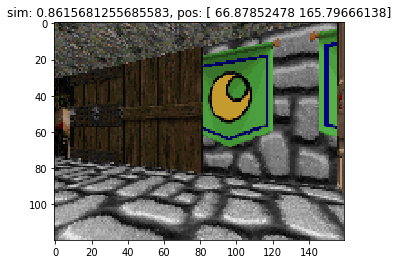

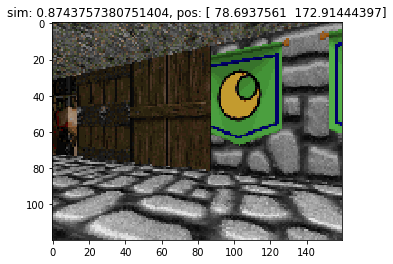

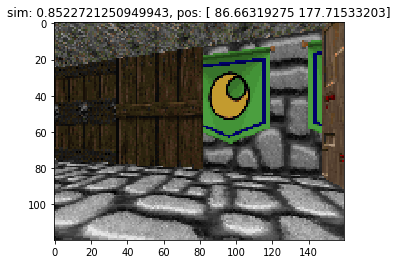

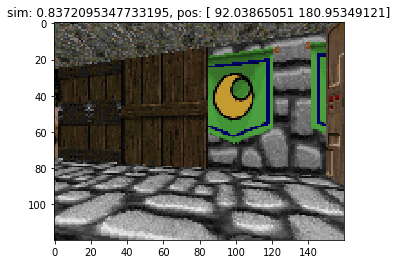

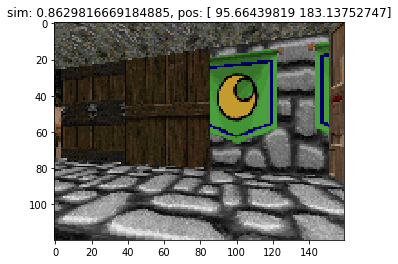

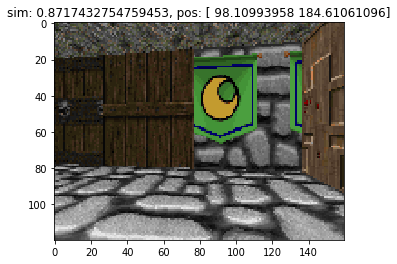

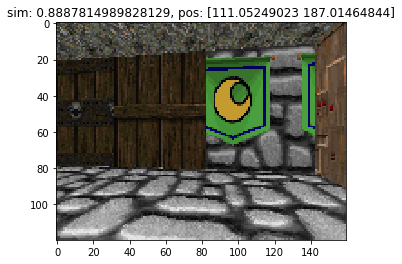

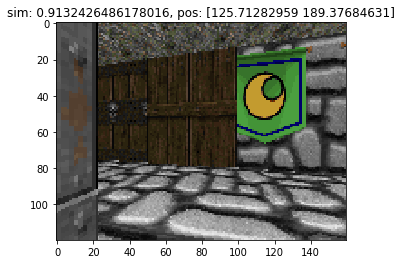

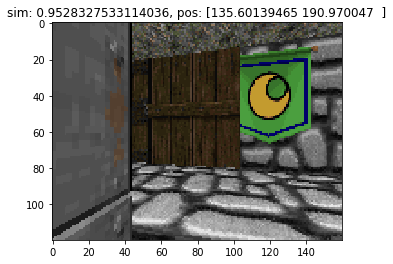

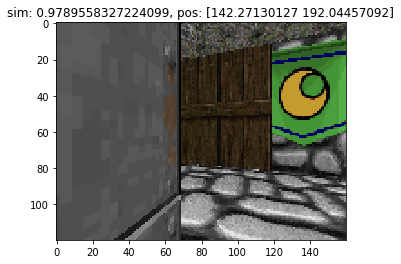

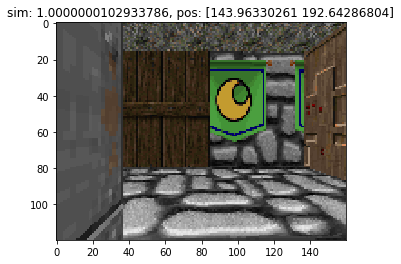

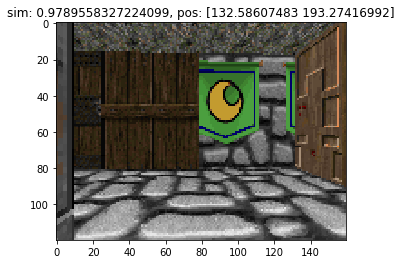

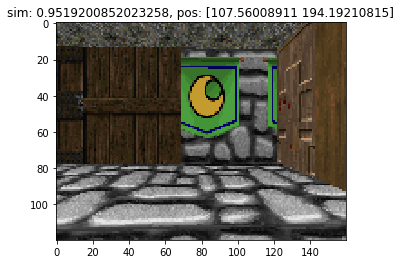

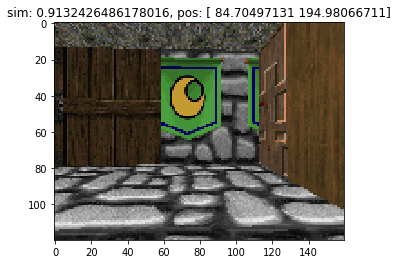

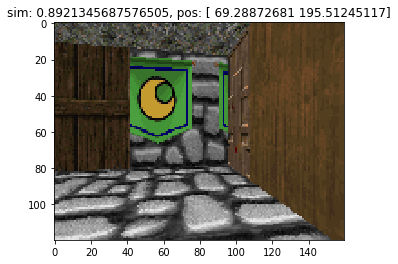

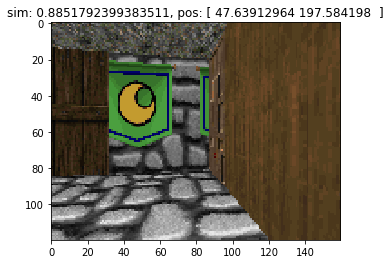

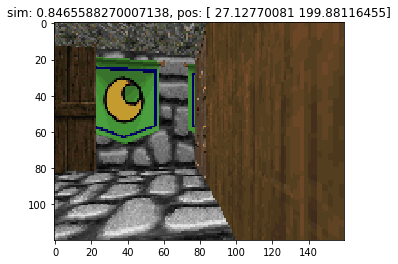

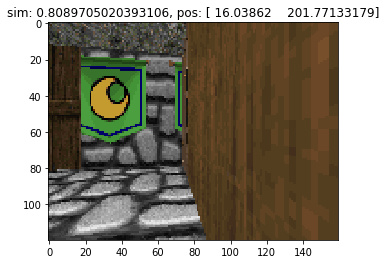

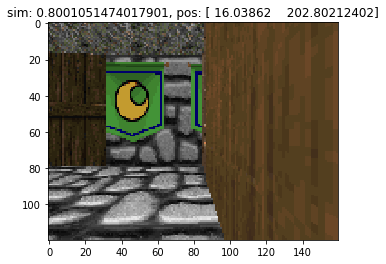

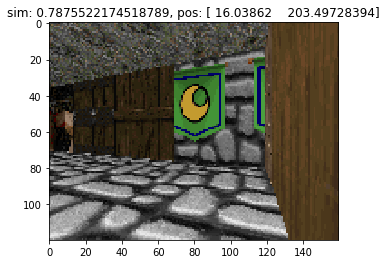

In [146]:
for sim, state, pos in zip(similarities[nearby], states[nearby], positions[nearby]):
    plt.figure()
    plt.imshow(np.transpose(state, [1, 2, 0]))
    plt.title('sim: {}, pos: {}'.format(sim, pos))

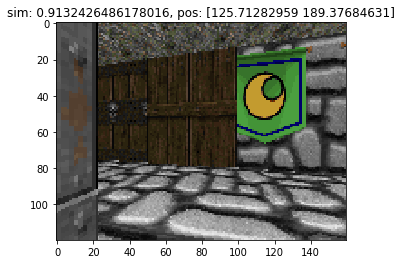

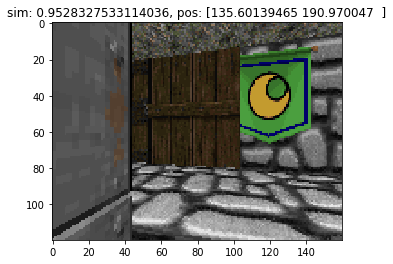

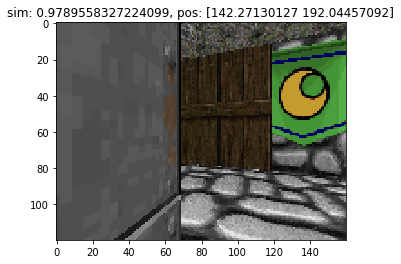

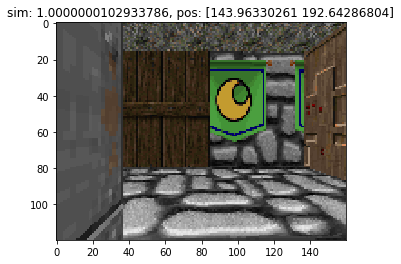

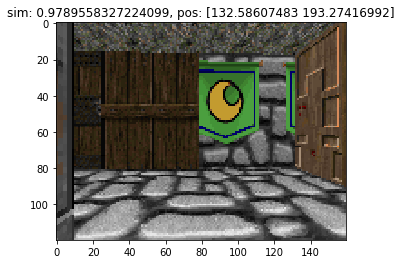

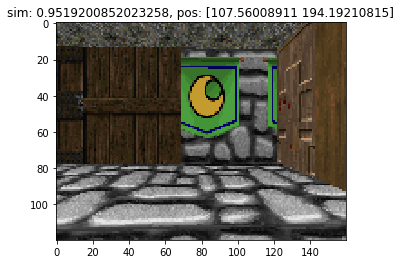

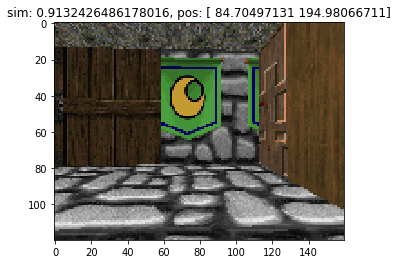

In [147]:
for sim, state, pos in zip(similarities[high_sim], states[high_sim], positions[high_sim]):
    plt.figure()
    plt.imshow(np.transpose(state, [1, 2, 0]))
    plt.title('sim: {}, pos: {}'.format(sim, pos))

/home/choang/anaconda3/envs/rlpyt/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


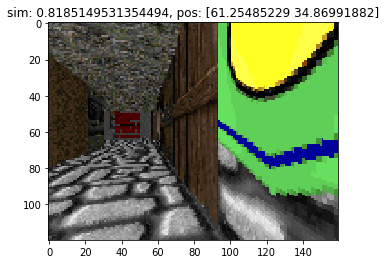

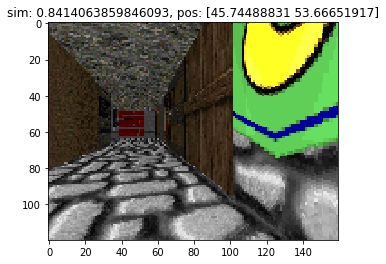

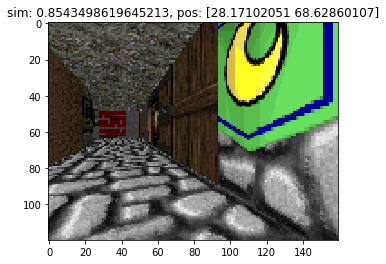

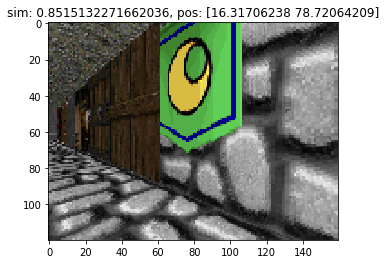

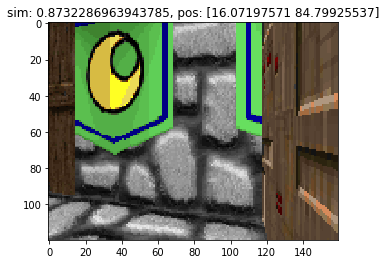

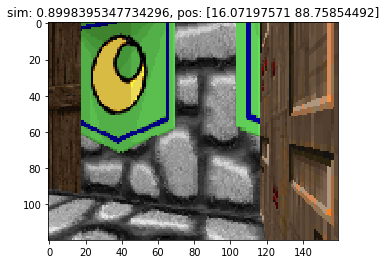

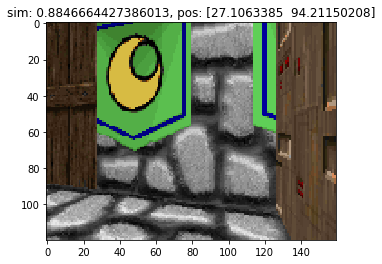

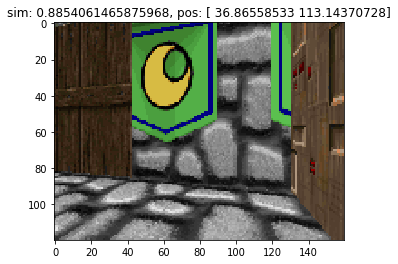

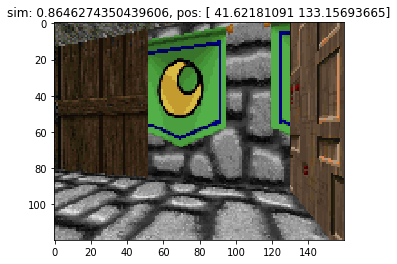

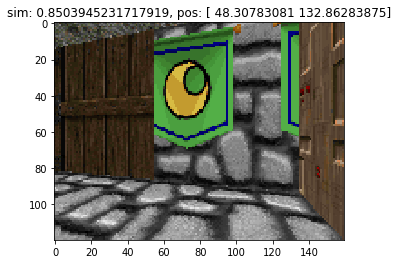

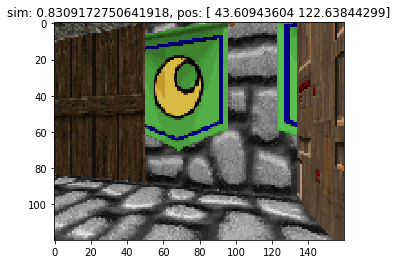

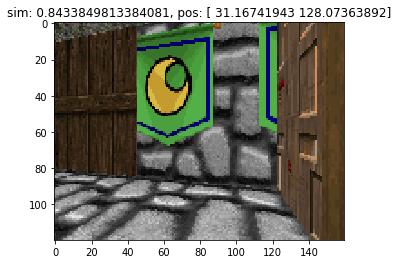

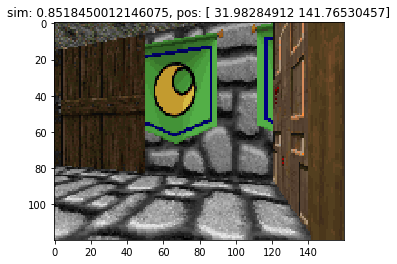

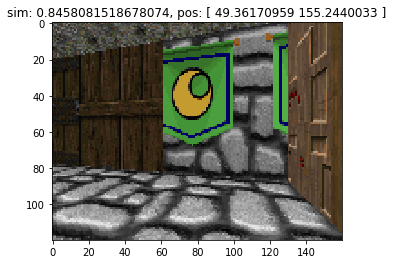

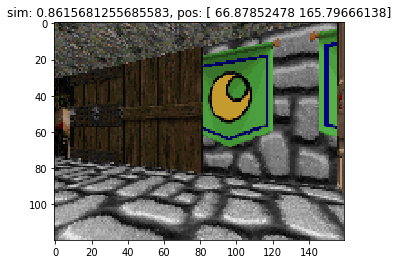

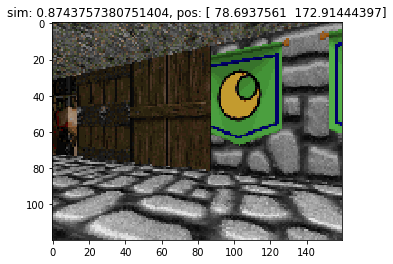

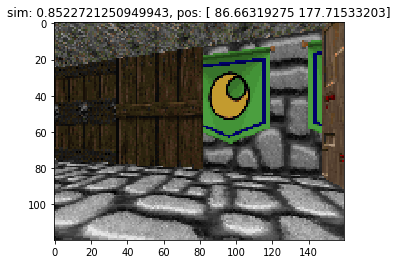

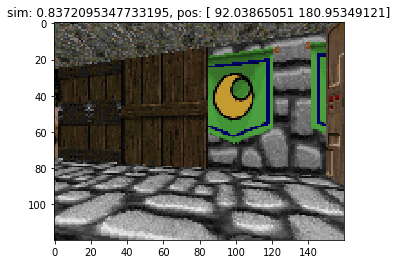

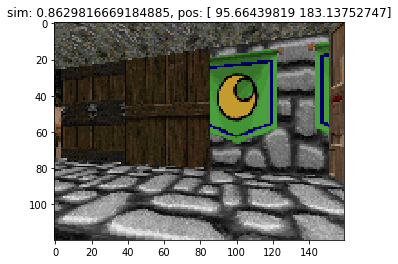

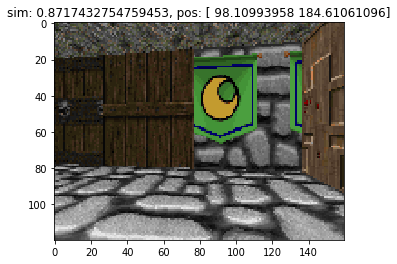

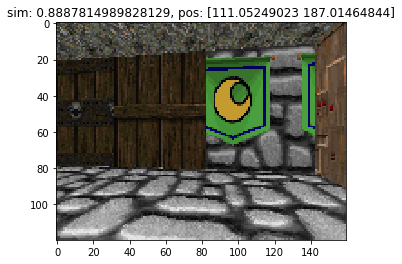

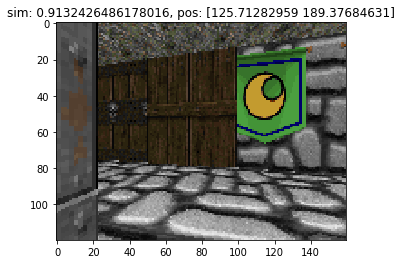

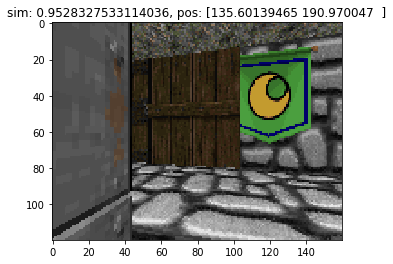

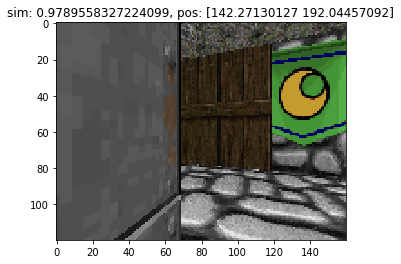

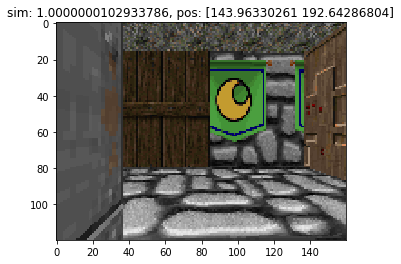

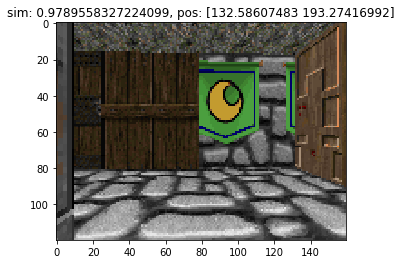

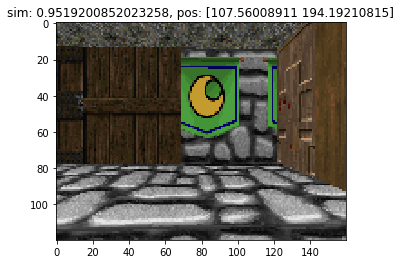

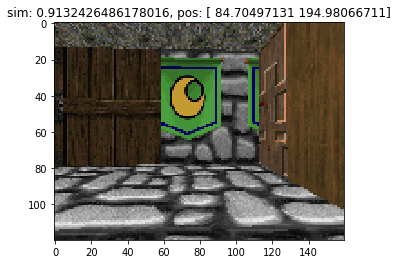

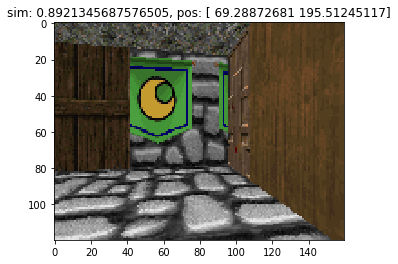

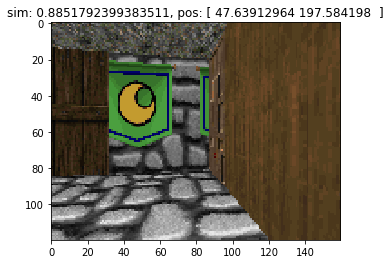

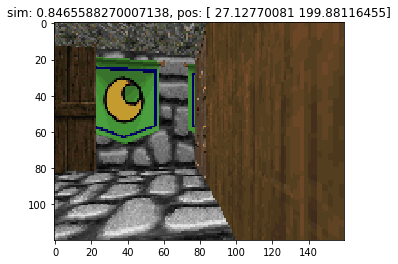

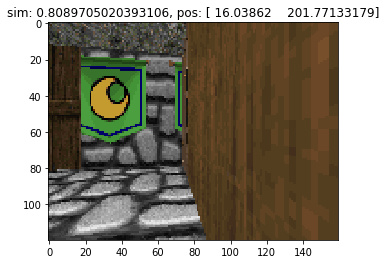

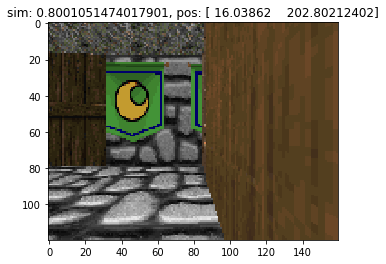

In [148]:
for sim, state, pos in zip(similarities[med_sim], states[med_sim], positions[med_sim]):
    plt.figure()
    plt.imshow(np.transpose(state, [1, 2, 0]))
    plt.title('sim: {}, pos: {}'.format(sim, pos))

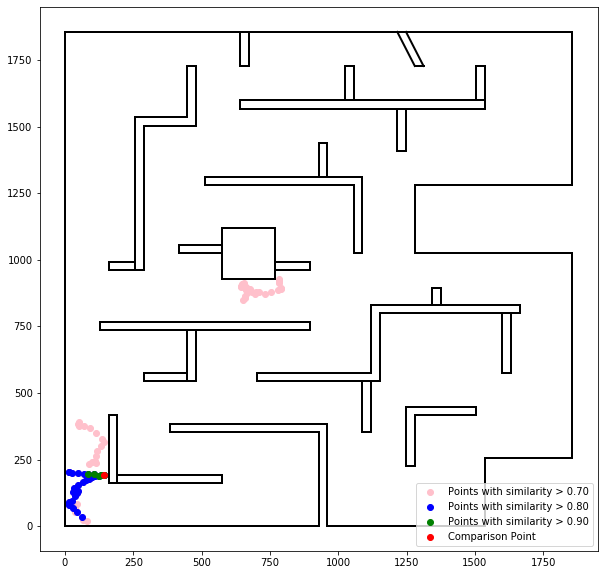

In [149]:
plt.figure(figsize=(10, 10))
env.plot_topdown(objects=False)
plt.scatter(positions[low_sim, 0], positions[low_sim, 1], c='pink', label='Points with similarity > 0.70')
plt.scatter(positions[med_sim, 0], positions[med_sim, 1], c='blue', label='Points with similarity > 0.80')
plt.scatter(positions[high_sim, 0], positions[high_sim, 1], c='green', label='Points with similarity > 0.90')
plt.scatter(positions[compare_idx, 0], positions[compare_idx, 1], c='red', label='Comparison Point')
plt.legend()

In [92]:
nearby = range(compare_idx - 20, compare_idx + 20)

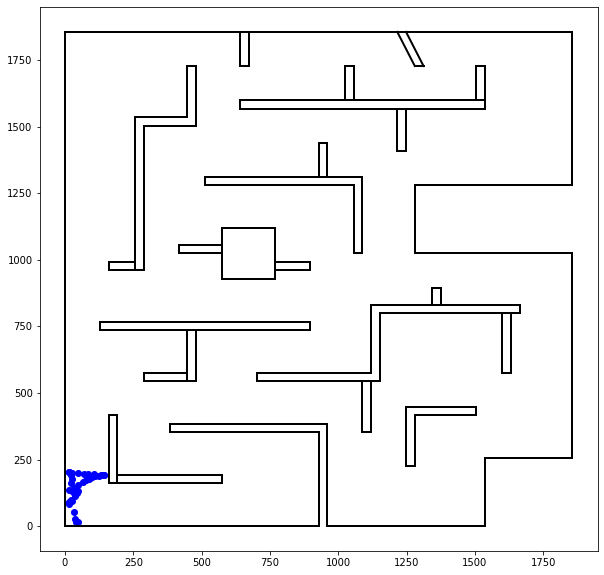

In [93]:
plt.figure(figsize=(10, 10))
env.plot_topdown(objects=False)
plt.scatter(positions[nearby, 0], positions[nearby, 1], c='blue')

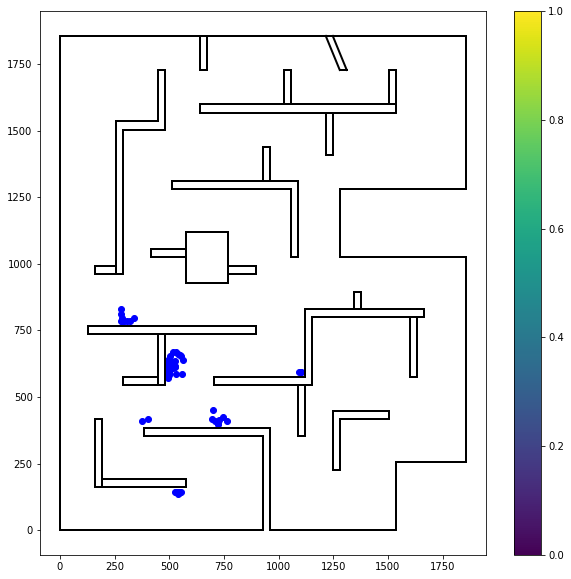

In [24]:
plt.figure(figsize=(10, 10))
env.plot_topdown(objects=False)
# plt.scatter(positions[high_sim, 0], positions[high_sim, 1], c='green')
plt.scatter(positions[stacked_high_sim, 0], positions[stacked_high_sim, 1], c='blue')
# plt.scatter(positions[med_sim & ~high_sim, 0], positions[med_sim & ~high_sim, 1])
# plt.scatter(positions[::4, 0], positions[::4, 1], c=similarities[::4])
plt.colorbar()

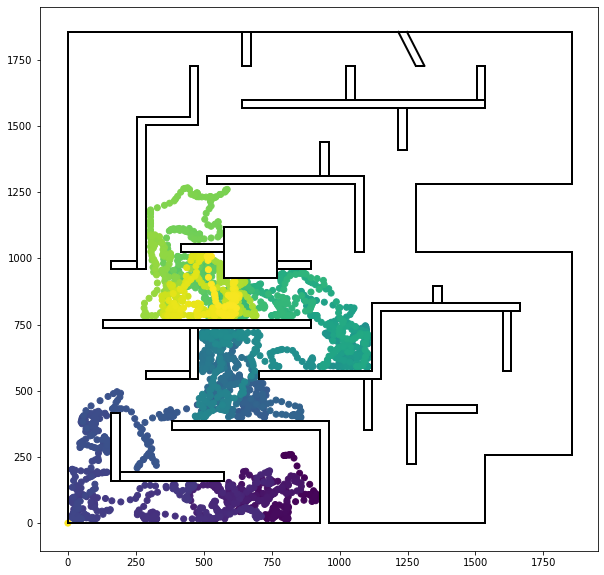

In [25]:
plt.figure(figsize=(10, 10))
env.plot_topdown(objects=False)
plt.scatter(positions[:, 0], positions[:, 1], c=np.arange(len(states)))

## MyWayHome

In [ ]:
env = VizDoomEnv('../experiments/vizdoom/my_way_home_SPTM.cfg', 0, [1040, -300], 270, grayscale=False)

In [ ]:
env.plot_topdown()
plt.scatter(env.sample_sectors[:, 0], env.sample_sectors[:, 1], c=env.sample_sectors[:, 2], s=100)

In [ ]:
for state, position in env.sample_states:
    plt.figure(figsize=(7, 7))
    plt.imshow(np.transpose(state, [1, 2, 0]))
    plt.title('{} {}'.format(*position))

In [ ]:
obs = env.reset()

In [ ]:
env.plot_topdown()

In [ ]:
plt.imshow(env.goal_state[-1], cmap='gray')

In [ ]:
env.plot_topdown()

In [ ]:
state = env.state

In [ ]:
state.sectors[0].lines[5].y2

In [ ]:
env.goal_position

In [ ]:
env.game.get_game_variable(vzd.GameVariable.ANGLE)

In [ ]:
env.game.send_game_command("warp 200 -200")

In [ ]:
obs, reward, done, info = env.step(3)

In [ ]:
done

In [ ]:
env.state.game_variables

In [ ]:
plt.imshow(obs[-1], cmap='gray')

In [ ]:
for i in range(500):
    obs, reward, done, info = env.step(np.random.randint(3))
    if done:
        print(reward, i + 1)
        break

In [ ]:
env.plot_topdown()

In [ ]:
plt.imshow(env.visited.T, origin='lower')

## Testing SPTM Retrieval Network

In [ ]:
game = vzd.DoomGame()
game.load_config('vizdoom_data/train_SPTM_control.cfg')
game.set_doom_map('map%02d' % 5)
game.set_screen_resolution(vzd.ScreenResolution.RES_640X480)
game.set_mode(vzd.Mode.SPECTATOR)
game.set_seed(100)
game.set_window_visible(True)

In [ ]:
game.init()
game.new_episode()
new_episode = True
while not game.is_episode_finished():
    s = game.get_state()
    if new_episode:
        print(s.game_variables)
        new_episode = False
    game.advance_action()
    a = game.get_last_action()
    r = game.get_last_reward()
game.close()

In [ ]:
env = VizDoomEnv('vizdoom_data/train_SPTM.cfg', 100, [1600, 1500], grayscale=False, map_id=5)

In [ ]:
for state, position in env.sample_states:
    print(position)

In [ ]:
model = resnet.ResnetBuilder.build_siamese_resnet_18((6, 120, 160), 2)

In [ ]:
model.load_weights('../../sptm/experiments/0103_R/models/model_weights.h5')

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
def get_features(state, norm=True):
    model_input = np.expand_dims(np.transpose(state, [1, 2, 0]), 0)
    features = model.layers[3].predict(model_input).squeeze()
    if norm:
        features = features / np.linalg.norm(features, ord=2)
    return features
def get_edge_prediction(A, B):
    concat = np.concatenate((A, B), axis=0)
    model_input = np.expand_dims(np.transpose(concat, [1, 2, 0]), 0)
    return model.predict(model_input)[:, 1]
def get_valid(data, m=3):
    return abs(data - np.mean(data)) < m * np.std(data)

In [ ]:
start_state, start_position = env.get_obs_at((1200, 1000))
start_state_features = get_features(start_state)

In [ ]:
sample_x = np.random.randint(env.min_x, env.max_x, 100)
sample_y = np.random.randint(env.min_y, env.max_y, 100)
samples = []
sample_states = []

In [ ]:
for x, y in zip(sample_x, sample_y):
    state, position = env.get_obs_at((x, y))
    features = get_features(state)
    similarity = np.dot(features, start_state_features)
    prediction = get_edge_prediction(start_state, state).item()
    samples.append((*position, similarity, prediction))
    sample_states.append(state)
samples = np.array(samples)

In [ ]:
env.plot_topdown()
plt.scatter(samples[:, 0], samples[:, 1], c=samples[:, 3], s=81)
plt.scatter(*start_position, marker='D')
plt.colorbar()